In [1]:
# get packages
from scipy.optimize import curve_fit
import scipy
import numpy as np
import matplotlib.pyplot as plt


#plt.rcParams['xtick.labelsize'] = 20
from nptdms import TdmsFile
#import cv2
from PIL import Image
import fnmatch
import os, sys
import trackpy as tp
from copy import deepcopy
from IPython.display import clear_output
from ipywidgets import interact
from nptdms import TdmsFile # this library contains the actual TDMS loading parts
import pandas as pd
from scipy import stats
import copy
import glob
import matplotlib

In [2]:
fdir = 'E:/' # set the "Select Files..." dialog start directory to the notebook directory
def openFilesDialog(fdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", fdir, filter='HDF5 Files (*.h5);;All Files (*)')
    return files[0]

In [90]:
## load data
dataset = '13JP_Interaction_BOX_expo40ms_'

In [98]:
#look for files with name
file_list = []
for file in glob.glob(dataset + '*_spots.h5'):
    print(file)
    file_list.append(file)

13JP_Interaction_BOX_expo40ms_1147_spots.h5
13JP_Interaction_BOX_expo40ms_1148_spots.h5


In [6]:
files = openFilesDialog(fdir)
fdir = os.path.dirname(files[0]) # set the dialog start directory to the selected directory

In [7]:
files

['E:/JP_Test_Data/10_JP_PS_1mu_WF_170mW_first_test_001_spots.h5']

### get the meta data from Trackerlab

In [8]:
#get metadata of a specified file
with pd.HDFStore(files[0]) as store:
    metadata = store['metadata']#.to_dict('records')[0]
    store.close()
    
metadata

,binning,dimx,dimy,exposure,frames,t_method,t_threshold,t_area_min,t_area_max
0,1,512,512,0.03,400,JP tracker multiple THs,2000,20,500


In [9]:
exposure_time = float(metadata.exposure)
dimx = int(metadata.dimx)

In [10]:
pxl_mu = 1
pxl_mu = 1

In [12]:
df = pd.DataFrame()
spots = pd.DataFrame()
for i, file in enumerate(files):
    with pd.HDFStore(file) as store:
        spots = store['spots']
        store.close()
    if i == 0:   
        f = spots
    else:
        spots['frame'] += f['frame'].max() + 50  # this is used to discriminate the different tdms seqences
        f = f.append(spots)

In [13]:
len(f.frame)

4159

In [14]:
np.max(f.frame)

399

In [15]:
f.head()

,area,bbox,eccentricity,frame,major_axis_length,max_intensity,minor_axis_length,orientation,phi,x,y
0,77,"(83, 160, 94, 171)",0.734116,0,12.588879,8742,8.548147,-0.585276,-0.584532,164.779221,88.545455
0,152,"(146, 154, 160, 167)",0.396242,0,14.505620,13696,13.318276,1.445216,1.288018,160.000000,152.500000
0,132,"(168, 373, 181, 386)",0.212028,0,13.108564,13055,12.810524,-1.470269,0.131685,378.636364,174.007576
0,101,"(221, 231, 233, 242)",0.484934,0,12.276974,8658,10.736836,-1.467985,1.495552,236.138614,226.297030
0,68,"(278, 370, 289, 380)",0.721087,0,12.575079,5260,8.712573,-0.971822,2.125857,375.220588,282.485294


### a data filtering example

In [16]:
boundary_buffer = 20 # in pxl
f_filtered = f[(f.x> boundary_buffer) & (f.y > boundary_buffer) & (f.x< (dimx-boundary_buffer)) & (f.y <(dimx-boundary_buffer))]
f_filtered = f[np.sqrt((f.x-dimx/2)**2+(f.y-dimx/2)**2) < 90] # only look at circular region in the center of the image (active region)



In [17]:
## link the trajectory
t1 = tp.link_df(f_filtered,5,memory = 3);

Frame 399: 4 trajectories present


In [18]:
t1.to_csv('t1.csv')

In [19]:
t1 = pd.read_csv('t1.csv')

In [20]:
t1_filtered = t1

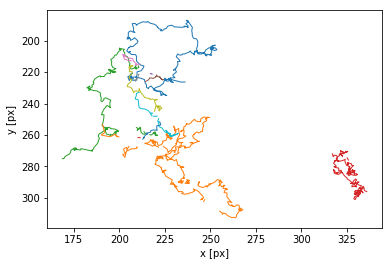

In [21]:
plt.figure()
tp.plot_traj(t1)



### plot phi distribution

/Users/Nic/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


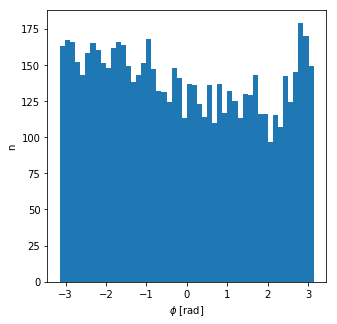

In [126]:
def Plot_phi_hist(t):
    fig, ax = plt.subplots(1, 1,figsize=(5,5))
    ax.hist(t.phi,bins = 50, normed = False)
    ax.set_xlabel('${\phi}$ [rad]')
    ax.set_ylabel('n')
    plt.show()
    return 
Plot_phi_hist(t1)

## below are some motion analysis scripts

In [77]:
def Make_Plot_dr(ax,dt = 1):
    #t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    #t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
    #                 & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
    #                ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    dr_list = np.zeros(len(t1_filtered['x']))
    #N = 0
    #dt =1
    n = 0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.x)>dt:
            x_data = (np.array(ptraj.x))
            y_data = (np.array(ptraj.y))
            dx = (x_data[dt:]-x_data[:-dt])
            dy = (y_data[dt:]-y_data[:-dt])
            dx_list[n:n+len(dx)] = dx
            dy_list[n:n+len(dx)] = dy
            dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
            n += len(dx)
    data = dr_list[dr_list!=0]
    N = len(data)
    n_bins = 150
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        A, mu, D = p
        #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        return A/np.sqrt(np.pi*4*D*dt*exposure_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposure_time*nth))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    
    def rayleigh(x,*p):
        A, D = p
        return 2*x/(4*D*dt*exposure_time*nth)*np.exp(-x**2/(4*D*dt*exposure_time*nth))
    
    def dphi_dist2(phi,*p):
        A, sigma  = p
        #A = 1                                      
        #sigma = 0.1
        N = 20
        theta_range = np.linspace(1,N,N)/(N+1)*np.pi
        dtheta = 2*np.pi/(N+1)
        value = 0
        mirror_list = [-1,0,1]
        for theta in theta_range:
            for i in mirror_list: # this is for large delta ts, dont know if thi is ok, but you know who cares... (no rly i think its ok)
                value += 1/4/np.sqrt(2*np.pi*sigma**2) * np.sin(theta)**2* np.exp(-(phi+i*2*np.pi)**2*np.sin(theta)**2 / (2.*sigma**2))*dtheta
            ## the 1/4 should be 1/2 theoretically but it turns out htat the normalisaiton demands 1/4...
        return A * value
    p1 = [1,1]
    
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
    coeff3, var_matrix3 = curve_fit(rayleigh, bin_centres, hist, p0=p1)
    D_rayl = coeff3[1]
    mean = coeff[1]  # write the mean innto the matrix
    D = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    #mean2 = np.mean(data)
    #uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)

    hist_fit = gauss(bin_centres, *coeff)
    hist_fit_rayl = rayleigh(bin_centres, *coeff3)
    #hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    ax.semilogy(np.array(bin_edges_mid)*pxl_mu, hist,color = 'black')
    ax.semilogy(bin_centres*pxl_mu, hist_fit_rayl, label='$\mathrm{Rayleigh\;fit}$', color = 'red')
    #plt.xlim(np.min(data),np.max(data))
    ax.set_ylim(ymin=10**-4)
    ax.legend(fontsize=12)
    ax.set_title('$dr$'+ ' hist')
    ax.text(0.53, 0.8,#' $\sigma$ =' + str(format(std*pxl_mu, '.3g'))+ ' $\mu m$  ;  '  
            #+ '$D_t$ =  '+str(format(std**2/2/exposure_time*pxl_mu**2/nth/dt, '.2g')) + ' $\mu m^2/s$'  ,
             '$D_t =$  '+str(format(D_rayl*pxl_mu**2, '.3g')) + ' $\mu m^2/s$' 
            + '\n' + '$dt = $ '+ str(format(dt*exposure_time*nth*1000, '.3g')) + ' $ms$',
            fontsize = 12,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    ax.set_xlim(xmax=np.max(bin_centres*pxl_mu))
    ax.set_xlabel('$dr\;\mathrm{\mu m}$')
    ax.set_ylabel('$\mathrm{counts/N}$')
    return


In [78]:
def Make_Plot_dx(ax,dt=1):
    #t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    #t1_filtered = t_to_use
    #t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
    #                 & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
    #                ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    #N = 0
    #dt =1
    n = 0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.x)>dt:
            x_data = (np.array(ptraj.x))
            y_data = (np.array(ptraj.y))
            #dx = (x_data[dt:]-x_data[:-dt])
            #dy = (y_data[dt:]-y_data[:-dt])
            
            
            #x_data = (np.array(ptraj.x)) #non rolling, stat indi
            #y_data = (np.array(ptraj.y))
            #dx = (x_data[::dt][1:]-x_data[::dt][:-1])
            #dy = (y_data[::dt][1:]-y_data[::dt][:-1])
            #dx_list[n:n+len(dx)] = dy
            #n += len(dx)
            
            if 1: #roling
                dx = (x_data[dt:]-x_data[:-dt])
                dy = (y_data[dt:]-y_data[:-dt])
                dx_list[n:n+len(dx)] = dx
                dy_list[n:n+len(dx)] = dy
                #dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
                n += len(dx)
            else: # stat. indi.
                dx = (x_data[::dt][1:]-x_data[::dt][:-1])
                dy = (y_data[::dt][1:]-y_data[::dt][:-1])
                dx_list[n:n+len(dx)] = dx
                dy_list[n:n+len(dx)] = dy
                #dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
                n += len(dx)
            
            
    data = dx_list[dx_list!=0]
    N = len(data)
    n_bins = 80
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        A, mu, D = p
        #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        return A/np.sqrt(np.pi*4*D*dt*exposure_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposure_time*nth))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p1 = [1,1]
    
    
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
    mean = coeff[1]  # write the mean innto the matrix
    D = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    dx0_simple = np.mean(data)*pxl_mu/dt/exposure_time
    uncert_mean = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    D_simple = np.var(data)*pxl_mu**2/dt/exposure_time/2
    
    
    hist_fit = gauss(bin_centres, *coeff)
    #hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)

    ax.semilogy(np.array(bin_edges_mid)*pxl_mu, hist,color = 'black',label='$\mathrm{data}$')
    ax.semilogy(bin_centres*pxl_mu, hist_fit, label='$\mathrm{gauss\;fit}$', color = 'red')
    #plt.xlim(np.min(data),np.max(data))
    ax.set_ylim(ymin=10**-4)

    ax.legend(fontsize=12)
    #ax.grid(which='both')
    #ax.set_xlim(left = -5, right = 5)
    ax.set_title('$dx$'+ ' $\mathrm{hist}$')
    ax.text(0.03, 0.9,#' $\sigma$ =' + str(format(std*pxl_mu, '.3g'))+ ' $\mu m$  ;  '  
            #+ '$D_t$ =  '+str(format(std**2/2/exposure_time*pxl_mu**2/nth/dt, '.2g')) + ' $\mu m^2/s$'  ,
             '$dt = $ '+ str(format(dt*exposure_time*nth*1000, '.3g')) + ' $\mathrm{ms}$'
            #+ '\n'+ '$ \\frac{<dx^2>}{2dt}$  = '+str(format(D_simple, '.5g')) + ' $\mu m^2/s$'
            #+ '\n'+ '$ \\frac{<dx>}{dt}$  = '+str(format(dx0_simple, '.5g')) + ' $\mu m/s$'
            + '\n' + '$D_t =$  '+str(format(D*pxl_mu**2, '.3g')) + ' $\mathrm{\mu m^2/s}$',
            fontsize=12,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    ax.set_ylabel('$\mathrm{counts/N}$')
    ax.set_xlabel('$dx$ $\mathrm{[\mu m]}$')
    ax.set_ylim(ymax = 15*np.max(hist))
    ax.set_xlim(xmin = -3*np.std(data), xmax = 3*np.std(data))
    return

In [79]:
def Make_Plot_VAC(ax,logy = False,logx = False,fit=False):
    max_lagtime = 25
    VAC_list = []
    #t1_filtered = t_to_use
    std_l = []
    uncert_l = []
    for dt in range(0,max_lagtime):
        VAC_tmp = 0
        N = 0
        n = 0
        data_l = np.zeros(len(t1_filtered.x))
        if dt==0:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.x)>dt:
                    x_data = (np.array(ptraj.x))
                    y_data = (np.array(ptraj.y))
                    #VAC_tmp += np.sum((x_data[1:]-x_data[:-1])[:]*(x_data[1:]-x_data[:-1])[:] + (y_data[1:]-y_data[:-1])[:]*(y_data[1:]-y_data[:-1])[:])
                    L = len((x_data[1:]-x_data[:-1])[:])
                    data_l[n:n+L] = (x_data[1:]-x_data[:-1])*(x_data[1:]-x_data[:-1]) + (y_data[1:]-y_data[:-1])*(y_data[1:]-y_data[:-1])
                    #data_l[n:n+L] = (x_data[1:]-x_data[:-1])**2 + (y_data[1:]-y_data[:-1])**2
                    n += L
                    N += L
        else:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.x)>dt:
                    #x_data = (np.array(ptraj.x))
                    #y_data = (np.array(ptraj.y))
                    #VAC_tmp += np.sum((x_data[1:]-x_data[:-1])[:-dt]*(x_data[1:]-x_data[:-1])[dt:] + (y_data[1:]-y_data[:-1])[:-dt]*(y_data[1:]-y_data[:-1])[dt:])
                    x_data = (np.array(ptraj.x))
                    y_data = (np.array(ptraj.y))
                    #VAC_tmp += np.sum((x_data[1:]-x_data[:-1])[:-dt][::dt]*(x_data[1:]-x_data[:-1])[dt:][::dt] + (y_data[1:]-y_data[:-1])[:-dt][::dt]*(y_data[1:]-y_data[:-1])[dt:][::dt])
                    L = len((x_data[1:]-x_data[:-1])[:-dt][::dt])
                    data_l[n:n+L] = (x_data[1:]-x_data[:-1])[:-dt][::dt]*(x_data[1:]-x_data[:-1])[dt:][::dt] + (y_data[1:]-y_data[:-1])[:-dt][::dt]*(y_data[1:]-y_data[:-1])[dt:][::dt]
                    n += L
                    N += L
                    #N+=len((x_data[1:]-x_data[:-1])[:-dt])
        if N!=0:
            #VAC_list.append(VAC_tmp/N)
            VAC_list.append(np.mean(data_l[:n])/(exposure_time)**2*pxl_mu**2)
            std_l.append(np.std(data_l[:n])/(exposure_time)**2*pxl_mu**2)
            uncert_l.append(std_l[-1]/np.sqrt(n))
    VAC_list = np.array(VAC_list)
    uncert_l = np.array(uncert_l)
    print('third VAC = ', VAC_list[2])
    print('first VAC = ', VAC_list[0])
    #VAC_list = np.array(VAC_list/VAC_list[0])
    ax.scatter(np.linspace(1,len(VAC_list)+1,len(VAC_list))*exposure_time, VAC_list, label='$\mathrm{VAC\; (normalized)}$',color = 'black', facecolors='none', edgecolors='k')
    ax.errorbar(np.linspace(1,len(VAC_list)+1,len(VAC_list))*exposure_time, VAC_list, yerr = uncert_l, color = 'k',label ='$\mathrm{std/\sqrt{N}}$' ,ls = 'none')
    if fit:
        def expfit(x,*p):
            a, t = p
            return a*np.exp(-x/t)
        p0 = [1,1]
        indis = (np.linspace(1,len(VAC_list)+1,len(VAC_list))>3) & (np.linspace(1,len(VAC_list)+1,len(VAC_list))<23)
        t_fit = np.linspace(1,len(VAC_list),len(VAC_list))[indis]
        #coeff, var_matrix = curve_fit(expfit, t_fit, VAC_list[indis], p0=p0)

        coeff, var_matrix = curve_fit(expfit, t_fit, VAC_list[indis], p0=p0, sigma = uncert_l[indis],absolute_sigma=True)
        tau = coeff[1]
        f_fit = expfit(t_fit, *coeff)
        print('done VAC')
        ax.plot(t_fit*exposure_time,f_fit,label='$\mathrm{exp\;fit}$',c='r')
        ax.text(0.66, 0.65,' $\\tau_{corr}$ =' + str(format(tau*exposure_time, '.2f'))+ ' s',
                fontsize=12,
             horizontalalignment='left',
             verticalalignment='center',
             bbox=dict(facecolor='w', alpha=1),
             transform = ax.transAxes)
    matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
    
    ax.legend(fontsize = 12,scatterpoints = 1,numpoints = 1)
    if logx:
        ax.set_xscale('log')
    else:
        ax.set_xlim(xmin = -0.1)
    
    if logy:
        ax.set_yscale('log')
        ax.set_ylim(ymin = np.min(VAC_list[VAC_list>0]),ymax = 1.2* np.max(VAC_list))
        #ax.set_ylim(ymin = 4,ymax = 1.4* np.max(VAC_list))
    else:
        ax.set_ylim(ymin = np.min(VAC_list)-0.05*np.max(VAC_list), ymax = 1.2* np.max(VAC_list))
    print('done somthing')
    ax.set_ylabel(r'$ \langle \vec{v}_0\cdot \vec{v}_{dt} \rangle \;[\mathrm{\mu m^2/s^2}]$')
    ax.set_xlabel('$dt\;\mathrm{[s]}$')
    ax.set_title('$\mathrm{VAC}$')
    #print('tau fit = ', tau*exposure_time)
    return


In [80]:
def Make_Plot_MSD(ax,lagtime_ballistic = 5):
    max_lagtime = 200
    MSD_list = []
    MSD_uncert_list = []
    #t1_filtered = t_to_use
    
            
    for dt in range(1,max_lagtime):  # stat. indipendent
        
        dx = []
        dy = []
        for  pid, ptraj in t1_filtered.groupby('particle'):
            if len(ptraj.x)>dt:
                x_data = (np.array(ptraj.x))[::dt]*pxl_mu
                y_data = (np.array(ptraj.y))[::dt]*pxl_mu
                dx += list((x_data[1:]-x_data[:-1]))
                dy += list((y_data[1:]-y_data[:-1]))
        dx = np.array(dx)
        dy = np.array(dy)
        MSD_list.append(np.mean(dx**2 + dy**2))
        MSD_uncert_list.append(np.std(dx**2 + dy**2)/np.sqrt(len(dx)+1)* stats.t.ppf(0.98,len(dx)))
            
    
    MSD_list = np.array(MSD_list)
    MSD_uncert_list = np.array(MSD_uncert_list)
    def linfit(x, *p):
        D, y_0 = p
        return 4*D*(x) +y_0
    p0 = [10, 10.]
    def sqfit(x,*p):
        m, x_0, y_0 = p
        return m*(x)**2
    #p2 = [1, 1, 1]
    p2 = [6,0.2,1]
    p1 = [2,1,0.1,2,1,0]
    def fit2(x,*p):
        #a,m,y_0 = p
        v ,D, y_0= p
        #D = 0
        #y_0 = 0
        return v**2*x**2 + 4*D*x +y_0
    
    def theo_msd(t,*p):
        u,tau,D,alpha,b,y_0 = p
        return 4*D*t + alpha *u**2*tau**2*(b*t/tau + np.exp(-t/tau)-1)+y_0
    
    
    
    indis = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>90) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<150)
    indis2 = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>0) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<lagtime_ballistic)
    t_list = np.linspace(1,len(MSD_list),len(MSD_list))*exposure_time
    t_fit = np.linspace(1,len(MSD_list),len(MSD_list))[indis]
    t_fit2 = np.linspace(1,len(MSD_list),len(MSD_list))[indis2] 
    coeff, var_matrix = curve_fit(linfit, t_fit, MSD_list[indis], sigma = MSD_uncert_list[indis],absolute_sigma=True, p0=p0)
    coeff2, var_matrix2 = curve_fit(fit2, t_fit2, MSD_list[indis2], sigma = MSD_uncert_list[indis2],absolute_sigma=True, p0=p2)
    
    
    D_eff = coeff[0]
    v_2 = np.abs(coeff2[0])
    D_t2 = coeff2[1]
    y_01 = coeff[1]
    y_02 = coeff2[2]
    f_fit = linfit(t_fit, *coeff)
    f_fit2 = fit2(t_fit2, *coeff2)
    f_fit_sup = 4*D_eff*np.linspace(1,len(MSD_list)+1)
    
    ax.plot(np.linspace(1,len(MSD_list)+1,len(MSD_list))*exposure_time, MSD_list, label='$\mathrm{data}$',color = 'black')
    #ax.plot(t_fit*exposure_time,f_fit,label='$4D_{eff}t +y_0$',color = 'red')
    
    ax.plot(t_fit2*exposure_time,f_fit2,label='$v^2t^2+4D_tt + y_1$',color = 'orange')
    ax.fill_between(np.linspace(1,len(MSD_list)+1,len(MSD_list))*exposure_time, MSD_list + MSD_uncert_list, MSD_list - MSD_uncert_list,color='k', alpha = 0.2)
    #ax.text(0.585, 0.13,'$\mathrm{diffusive\;fit}$'
    #        + '\n' + ' $D_{eff}$ =' + str(format(D_eff/exposure_time, '.3g'))+ ' $\mathrm{ \mu m^2/ s}$'
    #        + '\n' + '$y_0$ = ' + str(format(y_01,'.2f')),
    #        fontsize = 12,
    #     horizontalalignment='left',
    #     verticalalignment='center',
    #     bbox=dict(facecolor='w', alpha=1),
    #     transform = ax.transAxes)
    ax.text(0.036, 0.66,'$\mathrm{ballistic\;fit}$'
            + '\n' +' $v$ =' + str(format(v_2/exposure_time, '.2g'))+ ' $\mathrm{ \mu m /s}$'
            + '\n' + ' $D_t$ =' + str(format(D_t2/exposure_time, '.2g'))+ ' $\mathrm{ \mu m^2 /s}$'
            + '\n' + ' $y_1$ =' + str(format(y_02, '.2g'))+ ' $\mathrm{ \mu m^2}$',
            fontsize = 12,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ $\mathrm{[\mu m^2]}$',
       xlabel='$dt\;[\mathrm{s}]$')
    ax.legend(loc=0,fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('$\mathrm{MSD}$')
    return

In [81]:
def Make_Plot_Dt_of_dt_via_dx_hist(ax):
    #t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    #t1_filtered = t1#[(np.isfinite(np.array(t1['dx'])))
                     #& (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
                    #];
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    dr_list = np.zeros(len(t1_filtered['x']))
    
    #N = 0
    max_dt = int(1.2*2/exposure_time)
    dt_list = np.linspace(1,max_dt,max_dt).astype('int')
    Dt_listx = np.zeros(len(dt_list))
    Dt_listy = np.zeros(len(dt_list))
    Dt_listr = np.zeros(len(dt_list))
    for i in range(len(dt_list)):
        dt = dt_list[i]
        n = 0
        for  pid, ptraj in t1.groupby('particle'):
            if len(ptraj.x)>dt:
                #x_data = (np.array(ptraj.x)) #rolling
                #y_data = (np.array(ptraj.y))
                #dx = (x_data[dt:]-x_data[:-dt])
                #dy = (y_data[dt:]-y_data[:-dt])
                x_data = (np.array(ptraj.x)) #non rolling, stat indi
                y_data = (np.array(ptraj.y))
                dx = (x_data[::dt][1:]-x_data[::dt][:-1])
                dy = (y_data[::dt][1:]-y_data[::dt][:-1])
                
                dx_list[n:n+len(dx)] = dx
                dy_list[n:n+len(dx)] = dy
                dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
                n += len(dx)
        datar = dr_list[:n]
        datay = dy_list[:n]
        datax = dx_list[:n]
        
        N = len(datax)
        n_bins = 80
        histx, bin_edgesx = np.histogram(datax, density=True,bins = n_bins)
        histy, bin_edgesy = np.histogram(datay, density=True,bins = n_bins)
        histr, bin_edgesr = np.histogram(datar, density=True,bins = n_bins)
        bin_centresx = (bin_edgesx[:-1] + bin_edgesx[1:])/2
        bin_centresy = (bin_edgesy[:-1] + bin_edgesy[1:])/2
        bin_centresr = (bin_edgesr[:-1] + bin_edgesr[1:])/2

        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            A, mu, D = p
            #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
            return A/np.sqrt(np.pi*4*D*dt*exposure_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposure_time*nth))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        
        def rayleigh(x,*p):
            A, D = p
            return 2*x/(4*D*dt*exposure_time*nth)*np.exp(-x**2/(4*D*dt*exposure_time*nth))
        p1 = [1,1]
        p0 = [0., 0.1, 1.]
        coeffx, var_matrixx = curve_fit(gauss, bin_centresx, histx, p0=p0)
        coeffy, var_matrixy = curve_fit(gauss, bin_centresy, histy, p0=p0)
        coeffr, var_matrixr = curve_fit(rayleigh, bin_centresr, histr, p0=p1)
        
        #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
        #mean = coeff[1]  # write the mean innto the matrix
        Dx = np.abs(coeffx[2])
        Dy = np.abs(coeffy[2])
        Dr = np.abs(coeffr[1])
        
        #Dx = np.var(datax)/2/exposure_time/dt
        #Dy =  np.var(datay)/2/exposure_time/dt
        #Dr =  np.mean(datar**2)/4/exposure_time/dt
        
        Dt_listx[i] = Dx*pxl_mu**2
        Dt_listy[i] = Dy*pxl_mu**2
        Dt_listr[i] = Dr*pxl_mu**2
    #mean2 = np.mean(data)
    #uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    ax.scatter(dt_list*exposure_time, Dt_listx,color='blue',label='$dx\mathrm{\;hist}$')
    ax.scatter(dt_list*exposure_time, Dt_listy,color='red',label='$dy\mathrm{\;hist}$')
    ax.scatter(dt_list*exposure_time, Dt_listr,color='black',label='$dr\mathrm{\;hist}$')
    ax.legend()
    ax.set_xscale("log", nonposx='clip')
    #ax.set_yscale("log", nonposx='clip')
    ax.set_xlim(xmax = 1.3*dt_list[-1]*exposure_time)
    #ax.set_xlim(left = -5, right = 5)
    ax.set_title(r'$D_t\;\mathrm{via\;width\;of\;}d\vec{x}\mathrm{\;hist}$')
    ax.set_xlabel('$dt$ $\mathrm{[s]}$')
    ax.set_ylabel('$D_t$ $\mathrm{[\mu m^2 /s]}$')
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    return

In [82]:
nth = 1

/Users/Nic/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in exp


third VAC =  2329.017741627241
first VAC =  4781.089983379804
done somthing


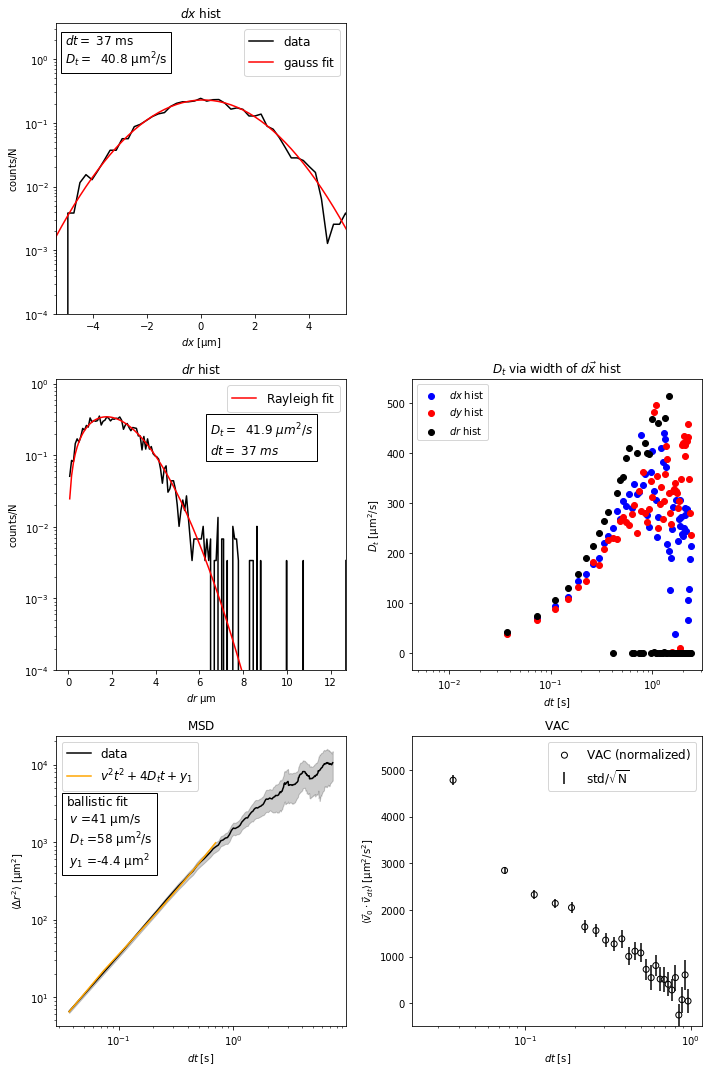

In [83]:
def Trans_free_bundle_plot(name = 'free'):
    f, ax = plt.subplots(3, 2,figsize=(10,15))
    plt.rcParams['patch.facecolor'] = 'white'
    
    #### dx parallel hist
    dt_list = [1,8]
    indi_list = [0,1]
    
    
    Make_Plot_dx(ax[0,0],dt=1)
    Make_Plot_dr(ax[1,0],dt=1)
    ###Make_Plot_dx(ax[1,0],dt=16)
    Make_Plot_Dt_of_dt_via_dx_hist(ax[1,1])
    Make_Plot_MSD(ax[2,0],lagtime_ballistic=20)
    Make_Plot_VAC(ax[2,1],logy=False,logx = True,fit=False)
    
    
    f.delaxes(ax[0,1])
    #f.delaxes(ax[1,1])

    
    plt.tight_layout()
    space = 0.3
    #plt.subplots_adjust(wspace=space, hspace=space)
    #plt.savefig(name + '_trans_bundle.pdf')
    
    return
Trans_free_bundle_plot()